In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from sklearn.utils import shuffle
from torch.nn import Transformer
import pickle
from torch.nn import functional as F

#plotting 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
###############################
#### Transformer Agent ########
###############################

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, decoder_mode=False):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)
        self.decoder_mode = decoder_mode

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        if self.decoder_mode:
            wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) #filter communication with past# comment this and you have an encoder block
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, decoder_mode=False):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, decoder_mode=decoder_mode) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, decoder_mode=False):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, decoder_mode=decoder_mode)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class TransformerModel(nn.Module):

    def __init__(self, decoder_mode=False):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head, decoder_mode=decoder_mode) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [3]:
# data loading
def get_batch(data):
    # data must be train trials encoded and transformed in torch tensor
    # generate a small batch of data of inputs x and targets y
    # data = train_tensor_encoded #if split == 'train' else val_data
    ix = torch.randint(len(data), (batch_size,)) 
    x = torch.stack([data[i,:block_size] for i in ix])
    y = torch.stack([data[i,1:] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    # data = train_tensor_encoded# Modify for train several models
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(data)
        logits, loss = model(X, Y)
        losses[k] = loss.item()
    out["train"] = losses.mean()
    model.train()
    return out

In [4]:
def get_trials_answers(tensor_encoded, model_trained, tell_me=True, tell_me_n_trials=1000):
    # tensor_encoded: Pytorch tensor long(float64) type [sample, comp_1, comp_2, comp_3, comp_response] of all group trials
    max_iters=tensor_encoded.shape[0]
    response_stimulus=[]
    for count, trial in enumerate(tensor_encoded[:,:-1]):
        tokens_response=model_trained.generate(trial.reshape([1,-1]), max_new_tokens=1)[0].tolist()
        response=decode(tokens_response)[-1]
        response_stimulus.append(response)

        if tell_me:
            # tell me the progress every tell_me_n_trials
            if count % tell_me_n_trials == 0 or count == max_iters - 1:
                print(f"{count} ({100.0*(count/max_iters):.2f}%) trials processed")
    return response_stimulus

In [5]:
###############################
  ####### FFN Agent ########
###############################

#### Agent train process function
def train_agent(
    train_trials_values,
    train_trials_answers, 
    hidden_layer_units = 25000, 
    n_epochs = 5000,
    batch_size=512
):
    # Randomize
    np_inputs, np_labels= shuffle(
        train_trials_values, 
        train_trials_answers)
    
    trial_input_length = np_inputs.shape[1]
    trial_output_length = np_labels.shape[1]
    
    # Define the network architecture
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(trial_input_length, hidden_layer_units)
            # self.fc2 = nn.Linear(hidden_layer_units, hidden_layer_units)
            self.fc3 = nn.Linear(hidden_layer_units, trial_output_length)
    
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            # x = torch.relu(self.fc2(x))
            x = self.fc3(x)  # identity activation function
            return x
    
    # Instantiate the network, the optimizer and the loss function
    net = Net().to(device)
    
    optimizer = torch.optim.Adam(net.parameters())
    criterion = nn.MSELoss()
    
    
    # Convert the new input data to a PyTorch tensor # Evaluation of train
    train_inputs = torch.from_numpy(train_trials_values).float().to(device)
    train_labels = torch.from_numpy(train_trials_answers).float().to(device)
    
    # Convert numpy arrays to PyTorch tensors # Inputs to train phase
    inputs = torch.from_numpy(np_inputs).float().to(device)
    labels = torch.from_numpy(np_labels).float().to(device)
    
    # Create a dataset and a data loader
    dataset = TensorDataset(inputs, labels)
    trainloader = DataLoader(dataset, batch_size=batch_size)
    
    epochs_errors_list = []
    # Training loop
    for epoch in range(n_epochs): # number of epochs
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs).to(device)
            loss = torch.sqrt(criterion(outputs, labels))  # RMSE
            loss.backward()
            optimizer.step()
    
            # print statistics
            running_loss = loss.item()
            # if (i == (train_labels.shape[0]//trainloader.batch_size)) & ((epoch % 50) == 0):  # print every 512 mini-batches
            #     print('epoch %5d  batch loss: %.4f' %
            #           (epoch, running_loss))
            #     running_loss = 0.0
        
        # Make predictions on the new data 
        with torch.no_grad():
            new_predictions = net(train_inputs) ### PERFORMANCE BOTTLENECK
        dat_RMSE = torch.sqrt(((torch.pow((new_predictions - train_labels), 2)).sum()) / new_predictions.shape[0])
        epochs_errors_list.append(dat_RMSE.item())
        
        if (epoch % int(n_epochs/20) == 0) or (dat_RMSE<.001) :
            clear_output(wait=True)
            plt.plot(range(len(epochs_errors_list)), 
                     epochs_errors_list, 
                     alpha = .8,
                     linewidth=.5
                    )
            plt.axhline(y=.0025, linestyle='--', c=sns.color_palette().as_hex()[2])
            plt.axhline(y=.001, linestyle='--', c=sns.color_palette().as_hex()[1])
            plt.title ("Error")
            plt.xlabel("Epoch")
            plt.ylabel("RMSE")
            plt.yscale('log')
            plt.show()
                    
        if dat_RMSE<.001: #.0005
            print("The RMSE of the train data evaluation falls below the criteria.")
            break
    print('Finished Training', str(dat_RMSE), str(epoch+1), "epochs")
    
    return net

def get_evaluation_responses(agent, test_trials_values, test_trials_answers, batch_size=512):
    # Convert the new input data to PyTorch tensors
    new_inputs = torch.from_numpy(test_trials_values).float().to(device)
    new_labels = torch.from_numpy(test_trials_answers).float().to(device)

    # Create a dataset and data loader
    dataset = TensorDataset(new_inputs, new_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Make predictions on the new data in batches
    with torch.no_grad():
        test_logits_list = []
        for inputs, labels in dataloader:
            test_logits = agent(inputs)
            test_logits_list.append(test_logits)

    # Concatenate the logits from all batches
    test_logits = torch.cat(test_logits_list, dim=0)

    # Calculate RMSE
    dat_RMSE = torch.sqrt(((torch.pow((test_logits - new_labels), 2)).sum()) / test_logits.shape[0])
    print("logits RMSE:", dat_RMSE.item())

    # Calculate softmax probabilities and response
    softmax = nn.Softmax(dim=1)
    test_probabilities = softmax(test_logits)
    test_response = torch.argmax(test_probabilities, dim=1)

    # Convert the predictions to a numpy array
    logits_np = test_logits.cpu().numpy()
    # probabilities_np = test_probabilities.cpu().numpy()
    response_np = test_response.cpu().numpy()

    return logits_np, response_np

In [6]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

In [7]:
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
print("device", device)

CUDA Available:  True
device cuda


In [8]:
%run ../utils/trials_v04a.py 

In [9]:
#############################################
#############  Experiment Parameters
members_number = 6#5#5
classes_number = 4#3#7
same_label_trials = True
############################################# 

filter_condition = ""
if same_label_trials:
    filter_condition = "filt"
else:
    filter_condition = "unfilt"

experiment_name = f"agents3_v04_m{members_number}_c{classes_number}_{filter_condition}"
folder_path = experiment_name+"/"

In [10]:
members_stim, class_stim, stimuli_set, dummy_set = get_stimuli_list(members_n = members_number, classes_n = classes_number)

In [11]:
protocols_dict = {f"{ts}_{relation}": {'train_structure': ts, 'relation_type': relation} 
                  for ts in ["LS", "OTM", "MTO"] for relation in [
                      'select_reject',
                      'select_only', 
                      'reject_only', 
                  ]}
list(protocols_dict.keys())

['LS_select_reject',
 'LS_select_only',
 'LS_reject_only',
 'OTM_select_reject',
 'OTM_select_only',
 'OTM_reject_only',
 'MTO_select_reject',
 'MTO_select_only',
 'MTO_reject_only']

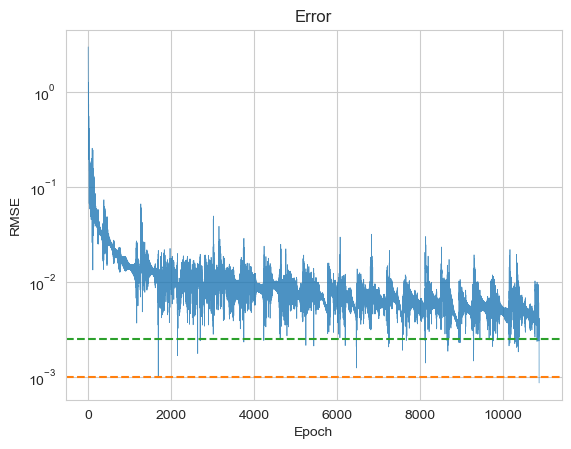

The RMSE of the train data evaluation falls below the criteria.
Finished Training tensor(0.0009, device='cuda:0') 10865 epochs
GPT agent
0 (0.00%) trials processed
259 (9.99%) trials processed
518 (19.98%) trials processed
777 (29.98%) trials processed
1036 (39.97%) trials processed
1295 (49.96%) trials processed
1554 (59.95%) trials processed
1813 (69.95%) trials processed
2072 (79.94%) trials processed
2331 (89.93%) trials processed
2590 (99.92%) trials processed
2591 (99.96%) trials processed
BERT agent
0 (0.00%) trials processed
259 (9.99%) trials processed
518 (19.98%) trials processed
777 (29.98%) trials processed
1036 (39.97%) trials processed
1295 (49.96%) trials processed
1554 (59.95%) trials processed
1813 (69.95%) trials processed
2072 (79.94%) trials processed
2331 (89.93%) trials processed
2590 (99.92%) trials processed
2591 (99.96%) trials processed
logits RMSE: 1.2458776235580444


In [12]:
#############################################
#############  LOOP PROTOCOLS
############################################# 
protocol_names=list(protocols_dict.keys())

for prt_nm in protocol_names:
    ##12
    print(prt_nm)
    protocol = protocols_dict[prt_nm]
    member_pairs_df = create_pair_members(members_stim, train_structure = protocol["train_structure"])
    experimental_pairs = create_pairs_classes(member_pairs_df, class_stim)
    ##13
    baseline_train_trials_info = create_trials(
        subset_to_trials = "baseline", 
        pairs_dataset_df = experimental_pairs, 
        stimuli_list = stimuli_set, 
        dummy_list = dummy_set, 
        relation_type = protocol['relation_type'],
        same_label_filter = same_label_trials
    )
    
    reflexivity_trials_info = create_trials(
        subset_to_trials = "reflexivity", 
        pairs_dataset_df = experimental_pairs, 
        stimuli_list = stimuli_set, 
        dummy_list = dummy_set, 
        relation_type = "select_reject",
        same_label_filter = same_label_trials
    )
    
    symmetry_trials_info = create_trials(
        subset_to_trials = "symmetry", 
        pairs_dataset_df = experimental_pairs, 
        stimuli_list = stimuli_set, 
        dummy_list = dummy_set, 
        relation_type = "select_reject",
        same_label_filter = same_label_trials
    )
    
    transitivity_trials_info = create_trials(
        subset_to_trials = "transitivity", 
        pairs_dataset_df = experimental_pairs, 
        stimuli_list = stimuli_set, 
        dummy_list = dummy_set, 
        relation_type = "select_reject",
        same_label_filter = same_label_trials
    )
    
    ##14
    #############################################
    ###   train Agents
    
    ##15
    trials_info_columns=["st_sample","st_comp1","st_comp2","st_comp3","option_answer"]#"st_comparison"
    train_trials_corpus_df=baseline_train_trials_info[trials_info_columns]
    ##16
    options_list = list(train_trials_corpus_df.option_answer.unique())
    ##17
    tokens_list = stimuli_set+dummy_set+options_list
    token_to_index = {token: index for index, token in enumerate(tokens_list)}
    ##18
    encoded_training_data = np.array([[token_to_index[token] for token in sequence] for sequence in np.array(train_trials_corpus_df)])
    train_tensor_encoded=torch.from_numpy(encoded_training_data).int().to(device)
    train_tensor_encoded=train_tensor_encoded.to(torch.long)
    ##19
    # set seed for reproductibility
    torch.manual_seed(183)
    
    # hyperparameters
    batch_size = 64 # how many independent sequences will we process in parallel?
    block_size = 4 # what is the maximum context length for predictions?
    max_iters = 10000
    eval_interval = 500
    learning_rate = 3e-4
    eval_iters = 200
    
    n_embd = 384
    n_head = 6
    n_layer = 6
    dropout = 0.2
    ##20
    # here are all the unique characters that occur in this text
    chars = tokens_list
    vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode = lambda l: [itos[i] for i in l]#lambda l: ','.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    ##21
    data=train_tensor_encoded
    ##22
    GPT_instance = TransformerModel(decoder_mode=True)
    GPT_model = GPT_instance.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in GPT_model.parameters())/1e6, 'M parameters')
    
    # create a PyTorch optimizer
    GPT_optimizer = torch.optim.AdamW(GPT_instance.parameters(), lr=learning_rate)
    model = GPT_model
    
    for iter in range(max_iters):
    
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            # print(losses)
            print(f"step {iter}: train loss {losses['train']:.4f}")
    
        # sample a batch of data
        xb, yb = get_batch(data)
    
        # evaluate the loss
        logits, loss = GPT_instance(xb, yb)
        GPT_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        GPT_optimizer.step()
    ##23
    BERT_instance = TransformerModel(decoder_mode=False)
    BERT_model = BERT_instance.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in BERT_model.parameters())/1e6, 'M parameters')
    
    
    # create a PyTorch optimizer
    BERT_optimizer = torch.optim.AdamW(BERT_instance.parameters(), lr=learning_rate)
    model = BERT_model
    
    for iter in range(max_iters):
    
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            # print(losses)
            print(f"step {iter}: train loss {losses['train']:.4f}")
    
        # sample a batch of data
        xb, yb = get_batch(data)
    
        # evaluate the loss
        logits, loss = BERT_instance(xb, yb)
        BERT_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        BERT_optimizer.step()
    ##24
    
    ##25
    ##### Encode Trials
    # This encoding can be used in a loop for validate stability across several experiments avoiding learning related to feature encoding positioning. 
    stimuli_dict_encoded = encode_stims (stimuli_set, dummy_set)
    ##26
    baseline_train_trials, baseline_train_answers = process_trial_values(
        baseline_train_trials_info, 
        stimuli_dict_encoded)
    ##27
    trained_agent = train_agent(
        train_trials_values = baseline_train_trials, 
        train_trials_answers = baseline_train_answers,
        hidden_layer_units = 50000, 
        n_epochs = 50000,
    )
    ##28
    
    ##29
    full_trials=pd.concat([
        baseline_train_trials_info,
        reflexivity_trials_info,
        symmetry_trials_info,
        transitivity_trials_info,
    ],ignore_index=True)
    
    ##30
    full_trials_corpus_df=full_trials[trials_info_columns]
    ##31
    # encode corpus in positional tokens
    encoded_full_trials_data = np.array([[token_to_index[token] for token in sequence] for sequence in np.array(full_trials_corpus_df)])
    full_trials_tensor_encoded=torch.from_numpy(encoded_full_trials_data).int().to(device)
    full_trials_tensor_encoded=full_trials_tensor_encoded.to(torch.long)
    ##32
    n_full_trials_report=int(full_trials_tensor_encoded.shape[0]/10)
    ##33
    print("GPT agent")
    trials_responses_GPT=get_trials_answers(full_trials_tensor_encoded, GPT_model, tell_me_n_trials=n_full_trials_report)
    print("BERT agent")
    trials_responses_BERT=get_trials_answers(full_trials_tensor_encoded, BERT_model, tell_me_n_trials=n_full_trials_report)
    ##34
    # Evaluate FFN
    full_trials_values, full_trials_answers = process_trial_values(
        full_trials, 
        stimuli_dict_encoded)
    
    full_trials_logits, full_trials_response = get_evaluation_responses (
        agent = trained_agent, 
        test_trials_values = full_trials_values, 
        test_trials_answers = full_trials_answers
    )
    
    trials_responses_FFN = ["O_"+str(rsp+1) for rsp in full_trials_response]
    ##35
    full_trials["GPT_response"]=trials_responses_GPT
    full_trials["BERT_response"]=trials_responses_BERT
    full_trials["FFN_response"]=trials_responses_FFN
    ##36
    full_trials['sample_member']=[stim[0] for stim in full_trials.st_sample]
    full_trials['comparison_member']=[stim[0] for stim in full_trials.st_comparison]
    
    full_trials["GPT_response_score"] = (full_trials["GPT_response"]==full_trials["option_answer"])*1
    full_trials["BERT_response_score"] = (full_trials["BERT_response"]==full_trials["option_answer"])*1
    full_trials["FFN_response_score"] = (full_trials["FFN_response"]==full_trials["option_answer"])*1
    
    ##37
    full_trials.to_pickle("salidas/"+folder_path+prt_nm+".pkl")

In [13]:
STOP!

SyntaxError: invalid syntax (2635050600.py, line 1)

In [ ]:
prt_nm = 1
same_label_trials = False

In [ ]:
protocol_names=list(protocols_dict.keys())
print(protocol_names[prt_nm])
protocol = protocols_dict[protocol_names[prt_nm]]
member_pairs_df = create_pair_members(members_stim, train_structure = protocol["train_structure"])
experimental_pairs = create_pairs_classes(member_pairs_df, class_stim)

In [ ]:
baseline_train_trials_info = create_trials(
    subset_to_trials = "baseline", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = protocol['relation_type'],
    same_label_filter = same_label_trials
)

reflexivity_trials_info = create_trials(
    subset_to_trials = "reflexivity", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject",
    same_label_filter = same_label_trials
)

symmetry_trials_info = create_trials(
    subset_to_trials = "symmetry", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject",
    same_label_filter = same_label_trials
)

transitivity_trials_info = create_trials(
    subset_to_trials = "transitivity", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject",
    same_label_filter = same_label_trials
)

In [ ]:
#############################################
###   train Agents

In [ ]:
trials_info_columns=["st_sample","st_comp1","st_comp2","st_comp3","option_answer"]#"st_comparison"
train_trials_corpus_df=baseline_train_trials_info[trials_info_columns]

In [ ]:
options_list = list(train_trials_corpus_df.option_answer.unique())

In [ ]:
tokens_list = stimuli_set+dummy_set+options_list
token_to_index = {token: index for index, token in enumerate(tokens_list)}

In [ ]:
encoded_training_data = np.array([[token_to_index[token] for token in sequence] for sequence in np.array(train_trials_corpus_df)])
train_tensor_encoded=torch.from_numpy(encoded_training_data).int().to(device)
train_tensor_encoded=train_tensor_encoded.to(torch.long)

In [ ]:
# set seed for reproductibility
torch.manual_seed(183)

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 4 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 500
learning_rate = 3e-4
eval_iters = 200

n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

In [ ]:
# here are all the unique characters that occur in this text
chars = tokens_list
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: [itos[i] for i in l]#lambda l: ','.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [ ]:
data=train_tensor_encoded

In [ ]:
GPT_instance = TransformerModel(decoder_mode=True)
GPT_model = GPT_instance.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in GPT_model.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
GPT_optimizer = torch.optim.AdamW(GPT_instance.parameters(), lr=learning_rate)
model = GPT_model

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        # print(losses)
        print(f"step {iter}: train loss {losses['train']:.4f}")

    # sample a batch of data
    xb, yb = get_batch(data)

    # evaluate the loss
    logits, loss = GPT_instance(xb, yb)
    GPT_optimizer.zero_grad(set_to_none=True)
    loss.backward()
    GPT_optimizer.step()

In [ ]:
BERT_instance = TransformerModel(decoder_mode=False)
BERT_model = BERT_instance.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in BERT_model.parameters())/1e6, 'M parameters')


# create a PyTorch optimizer
BERT_optimizer = torch.optim.AdamW(BERT_instance.parameters(), lr=learning_rate)
model = BERT_model

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        # print(losses)
        print(f"step {iter}: train loss {losses['train']:.4f}")

    # sample a batch of data
    xb, yb = get_batch(data)

    # evaluate the loss
    logits, loss = BERT_instance(xb, yb)
    BERT_optimizer.zero_grad(set_to_none=True)
    loss.backward()
    BERT_optimizer.step()

In [ ]:
########### FFN

In [ ]:
##### Encode Trials
# This encoding can be used in a loop for validate stability across several experiments avoiding learning related to feature encoding positioning. 
stimuli_dict_encoded = encode_stims (stimuli_set, dummy_set)

In [ ]:
baseline_train_trials, baseline_train_answers = process_trial_values(
    baseline_train_trials_info, 
    stimuli_dict_encoded)

In [ ]:
trained_agent = train_agent(
    train_trials_values = baseline_train_trials, 
    train_trials_answers = baseline_train_answers,
    hidden_layer_units = 50000, 
    n_epochs = 50000,
)

In [ ]:
###### evaluate test trials

In [ ]:
full_trials=pd.concat([
    baseline_train_trials_info,
    reflexivity_trials_info,
    symmetry_trials_info,
    transitivity_trials_info,
],ignore_index=True)

In [ ]:
full_trials_corpus_df=full_trials[trials_info_columns]

In [ ]:
# encode corpus in positional tokens
encoded_full_trials_data = np.array([[token_to_index[token] for token in sequence] for sequence in np.array(full_trials_corpus_df)])
full_trials_tensor_encoded=torch.from_numpy(encoded_full_trials_data).int().to(device)
full_trials_tensor_encoded=full_trials_tensor_encoded.to(torch.long)

In [ ]:
n_full_trials_report=int(full_trials_tensor_encoded.shape[0]/10)

In [ ]:
print("GPT agent")
trials_responses_GPT=get_trials_answers(full_trials_tensor_encoded, GPT_model, tell_me_n_trials=n_full_trials_report)
print("BERT agent")
trials_responses_BERT=get_trials_answers(full_trials_tensor_encoded, BERT_model, tell_me_n_trials=n_full_trials_report)

In [ ]:
# Evaluate FFN
full_trials_values, full_trials_answers = process_trial_values(
    full_trials, 
    stimuli_dict_encoded)

full_trials_logits, full_trials_response = get_evaluation_responses (
    agent = trained_agent, 
    test_trials_values = full_trials_values, 
    test_trials_answers = full_trials_answers
)

trials_responses_FFN = ["O_"+str(rsp+1) for rsp in full_trials_response]

In [ ]:
full_trials["GPT_response"]=trials_responses_GPT
full_trials["BERT_response"]=trials_responses_BERT
full_trials["FFN_response"]=trials_responses_FFN

In [ ]:
full_trials['sample_member']=[stim[0] for stim in full_trials.st_sample]
full_trials['comparison_member']=[stim[0] for stim in full_trials.st_comparison]

full_trials["GPT_response_score"] = (full_trials["GPT_response"]==full_trials["option_answer"])*1
full_trials["BERT_response_score"] = (full_trials["BERT_response"]==full_trials["option_answer"])*1
full_trials["FFN_response_score"] = (full_trials["FFN_response"]==full_trials["option_answer"])*1

In [ ]:
# full_trials.to_pickle("salidas/"+protocol_names[prt_nm]+".pkl")

In [ ]:
#####################################################
########### Explore trials

In [ ]:
members_number = 7#5#
classes_number = 5#3#

members_stim, class_stim, stimuli_set, dummy_set = get_stimuli_list(members_n = members_number, classes_n = classes_number)

In [ ]:
prt_nm = 1
same_label_trials = True

In [ ]:
protocol_names=list(protocols_dict.keys())
print(protocol_names[prt_nm])
protocol = protocols_dict[protocol_names[prt_nm]]
member_pairs_df = create_pair_members(members_stim, train_structure = protocol["train_structure"])
experimental_pairs = create_pairs_classes(member_pairs_df, class_stim)

In [ ]:
baseline_train_trials_info = create_trials(
    subset_to_trials = "baseline", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = protocol['relation_type'],
    same_label_filter = same_label_trials
)

reflexivity_trials_info = create_trials(
    subset_to_trials = "reflexivity", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject",
    same_label_filter = same_label_trials
)

symmetry_trials_info = create_trials(
    subset_to_trials = "symmetry", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject",
    same_label_filter = same_label_trials
)

transitivity_trials_info = create_trials(
    subset_to_trials = "transitivity", 
    pairs_dataset_df = experimental_pairs, 
    stimuli_list = stimuli_set, 
    dummy_list = dummy_set, 
    relation_type = "select_reject",
    same_label_filter = same_label_trials
)

In [ ]:
full_trials=pd.concat([
    baseline_train_trials_info,
    reflexivity_trials_info,
    symmetry_trials_info,
    transitivity_trials_info,
],ignore_index=True)

In [ ]:
# full_trials.to_csv("same_label_"+protocol_names[prt_nm]+".csv")